In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures


In [3]:
#load dataset
stellar_data_new = pd.read_csv('2-Dataset.csv')

In [4]:
# display dataset
print("\nDataset Information (Info):")
print(stellar_data_new.info()) 
print("\nDataset Statistical Summary (Describe):")
print(stellar_data_new.describe())



Dataset Information (Info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
d

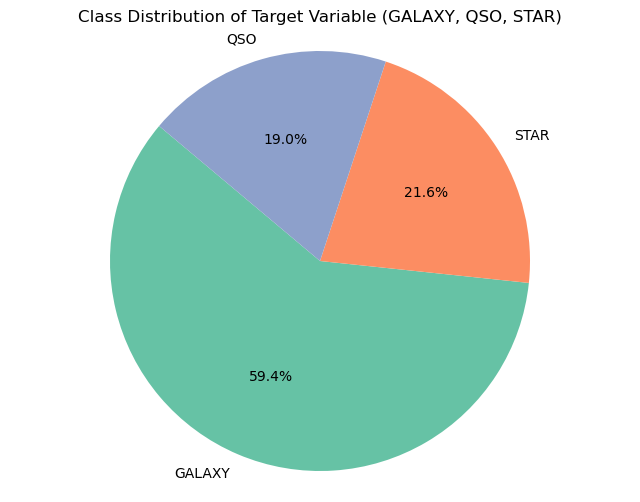

In [72]:
#visualize class distribution-pie chart
plt.figure(figsize=(8, 6))
class_distribution = stellar_data_new['class'].value_counts()
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2").as_hex())
plt.title('Class Distribution of Target Variable (GALAXY, QSO, STAR)')
plt.axis('equal')  
plt.show()
#shows how the different classes GALAXY, QSO, STAR are distributed in dataset.


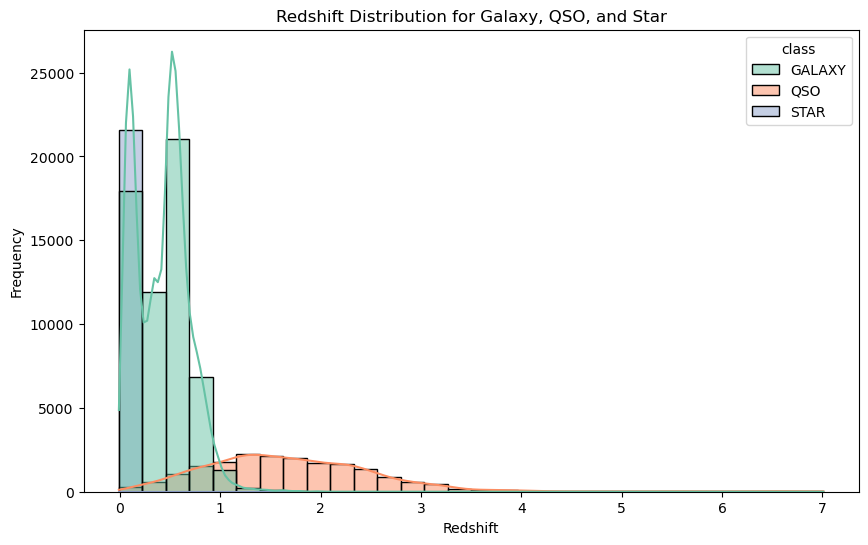

In [73]:
#redshift distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=stellar_data_new, x='redshift', hue='class', kde=True, bins=30, palette='Set2')
plt.title('Redshift Distribution for Galaxy, QSO, and Star')
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.show()

In [74]:
#feature selection and preprocessing.
#selecting relevant features.
features = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']
X = stellar_data_new[features]
y = stellar_data_new['class'] 

In [75]:
#handle missing data
X = X.fillna(X.mean())


In [76]:
#convert categorical target into numeric (0, 1, 2) for the models to work.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [77]:
#feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [78]:

#polynomial Features
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

In [79]:
# split the Data into Training and Testing Sets
#training (70%) and testing (30%).
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_encoded, test_size=0.3, random_state=42)


In [80]:
#initialize classifiers
#Logistic Regression, KNN, Random Forest, Gradient Boosting, XGBoost, Decision Trees.
logreg_classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
knn_classifier = KNeighborsClassifier()
xgboost_classifier = xgb.XGBClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')
gb_classifier = GradientBoostingClassifier(random_state=42)


In [81]:
#list to store evaluation results of models
model_results = []

In [82]:

#evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    #calculate accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    #calculate ROC-AUC if the model supports predict_proba
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    except AttributeError:
        roc_auc = "N/A" 
    
    model_results.append((model.__class__.__name__, accuracy, roc_auc, classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)))
    
    print(f"{model.__class__.__name__} Accuracy: {accuracy}")
    print(f"ROC-AUC: {roc_auc}\n")

In [83]:
#evaluate all models
evaluate_model(logreg_classifier, X_train, y_train, X_test, y_test)
evaluate_model(knn_classifier, X_train, y_train, X_test, y_test)
evaluate_model(rf_classifier, X_train, y_train, X_test, y_test)
evaluate_model(dt_classifier, X_train, y_train, X_test, y_test)
evaluate_model(gb_classifier, X_train, y_train, X_test, y_test)
evaluate_model(xgboost_classifier, X_train, y_train, X_test, y_test)

LogisticRegression Accuracy: 0.9525333333333333
ROC-AUC: 0.9903042177566114

KNeighborsClassifier Accuracy: 0.9402333333333334
ROC-AUC: 0.9760638749540976

RandomForestClassifier Accuracy: 0.9751
ROC-AUC: 0.9950891140763746

DecisionTreeClassifier Accuracy: 0.9638666666666666
ROC-AUC: 0.9671320600769837

GradientBoostingClassifier Accuracy: 0.9753666666666667
ROC-AUC: 0.9950147551456568

XGBClassifier Accuracy: 0.9755666666666667
ROC-AUC: 0.9954715799175317



In [84]:
#model Comparison
#sort models based on accuracy and ROC-AUC to see which model performed the best.
sorted_models = sorted(model_results, key=lambda x: x[1], reverse=True)

best_model_name, best_accuracy, best_roc_auc, best_class_report, best_conf_matrix = sorted_models[0]


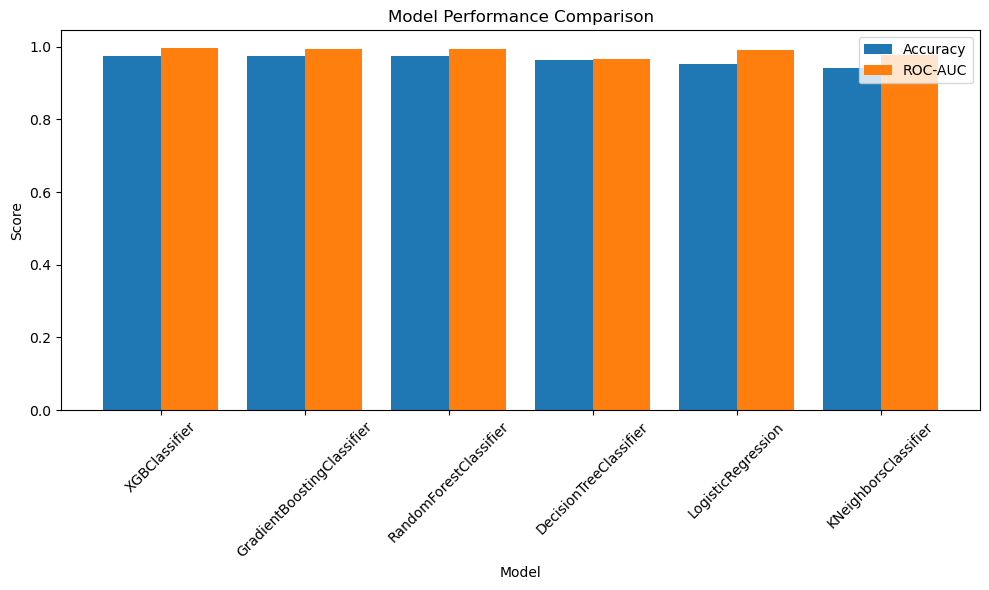

In [85]:
#visualize model performance comparison
model_names, accuracies, roc_aucs = zip(*[(result[0], result[1], result[2]) for result in sorted_models])

plt.figure(figsize=(10, 6))
x = np.arange(len(model_names))
plt.bar(x - 0.2, accuracies, 0.4, label='Accuracy')
plt.bar(x + 0.2, roc_aucs, 0.4, label='ROC-AUC')
plt.xticks(x, model_names, rotation=45)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()


Best Model: XGBClassifier
Accuracy: 0.9755666666666667
ROC-AUC: 0.9954715799175317

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17845
           1       0.96      0.92      0.94      5700
           2       0.99      1.00      0.99      6455

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



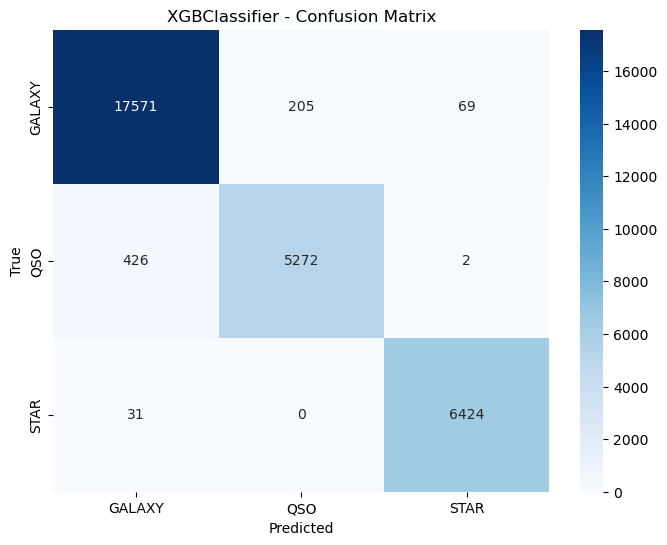

In [86]:
#best model evaluation
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {best_accuracy}")
print(f"ROC-AUC: {best_roc_auc}")
print("\nClassification Report:")
print(best_class_report)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f'{best_model_name} - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

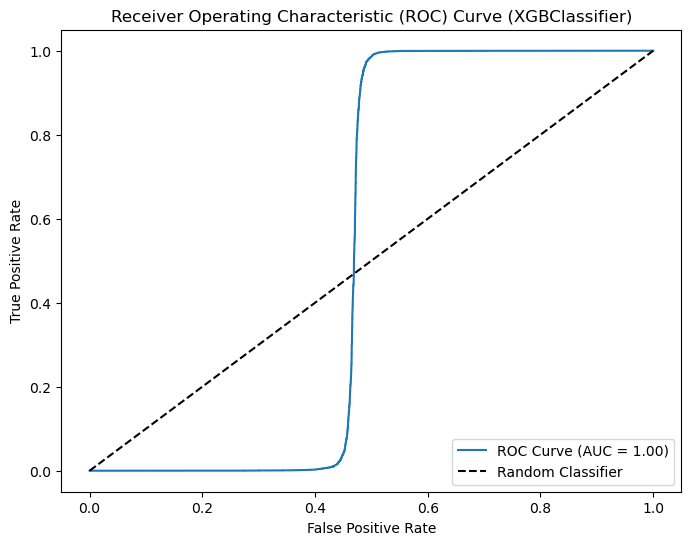

In [87]:
#ROC Curve for the Best Model
fpr, tpr, _ = roc_curve(y_test, xgboost_classifier.predict_proba(X_test)[:, 1], pos_label=label_encoder.transform(['GALAXY'])[0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {best_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve ({best_model_name})')
plt.legend(loc='lower right')
plt.show()


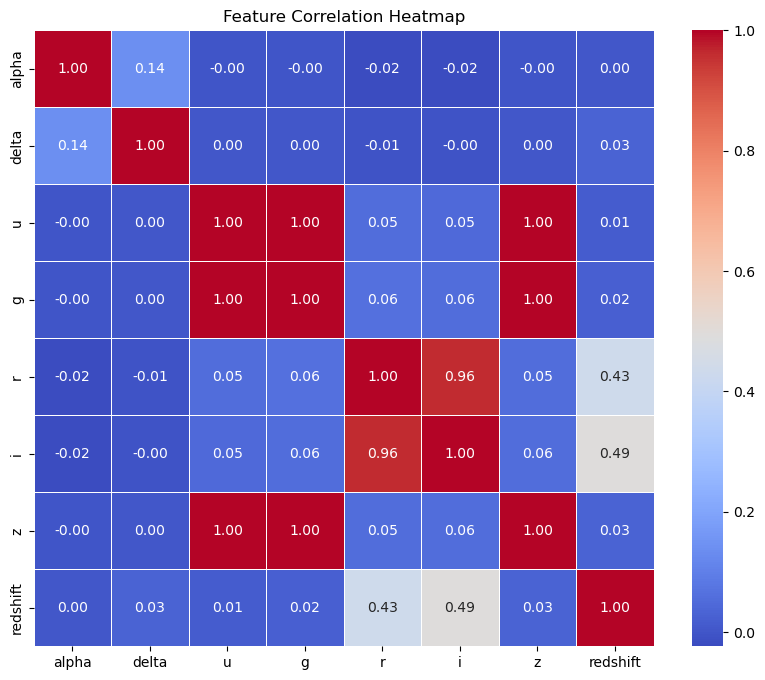

In [88]:
#Heatmap: Correlation between Features
plt.figure(figsize=(10, 8))
corr_matrix = stellar_data_new[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

c:\Users\sivaa\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\sivaa\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


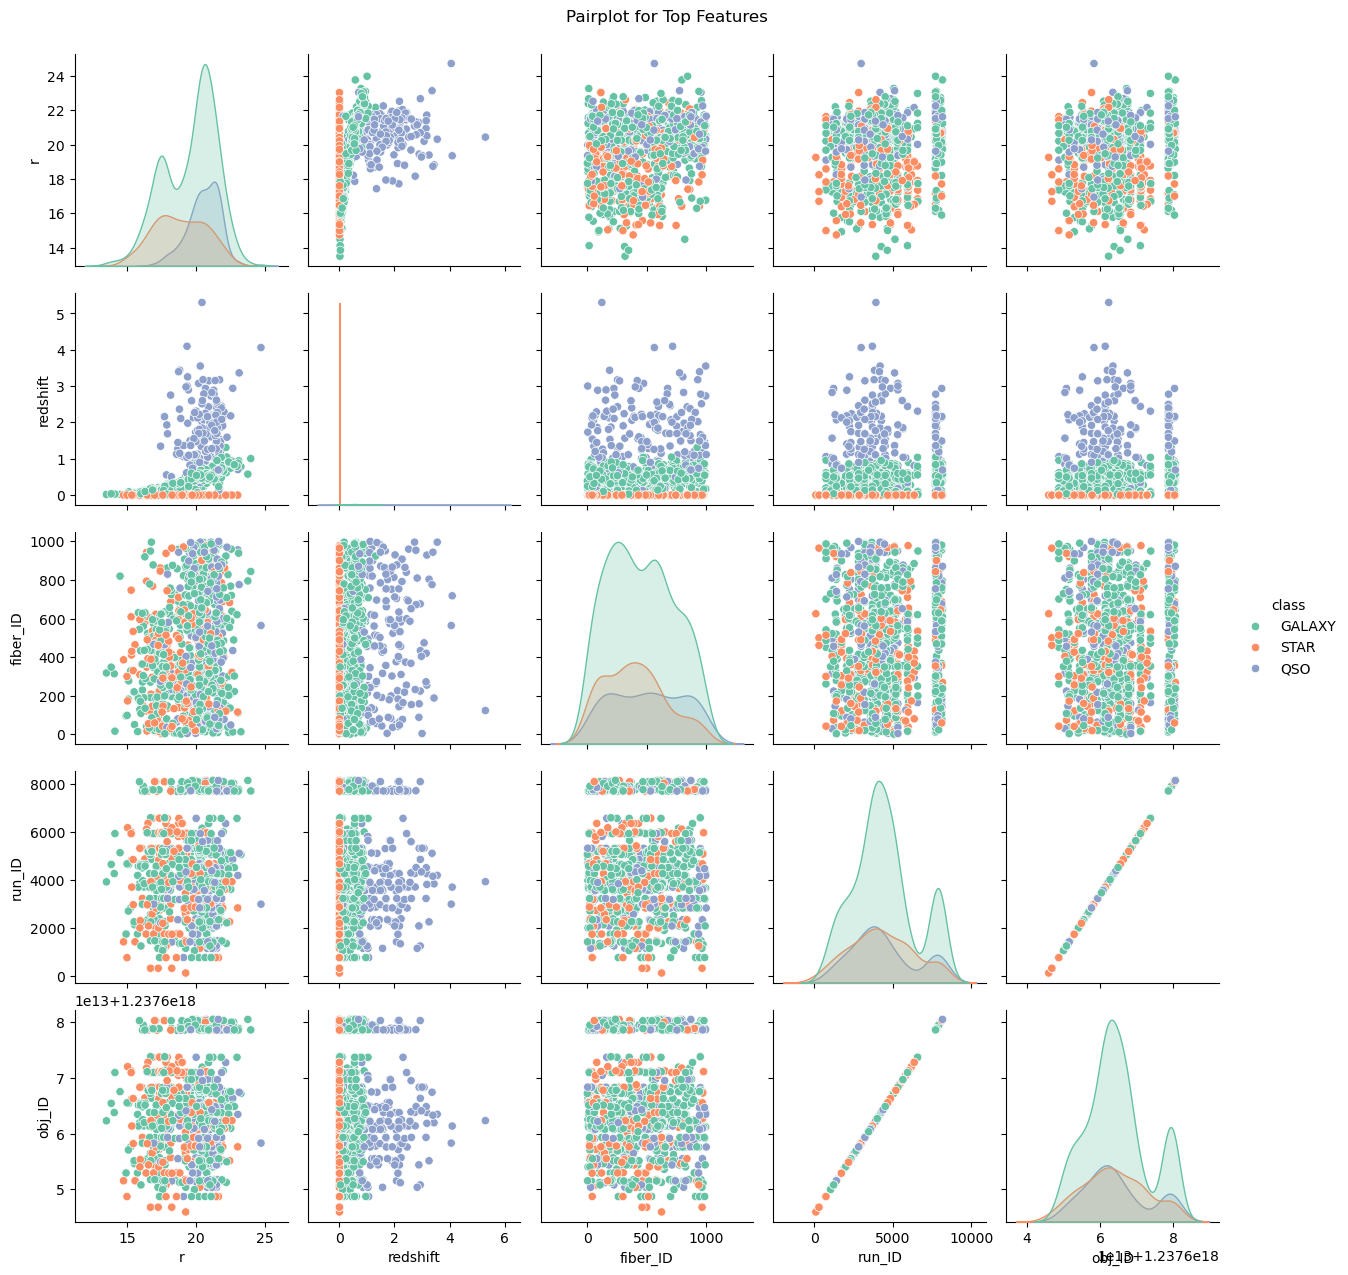

In [89]:
#pairplot

encoded_target = pd.Series(label_encoder.transform(stellar_data_new['class']), name='class_encoded')
numeric_data = stellar_data_new.drop(columns=['class'])
correlation_with_target = numeric_data.corrwith(encoded_target)

#select top 5 features with the highest absolute correlation to the target
top_features = correlation_with_target.abs().sort_values(ascending=False).index[:5]

pairplot_data = stellar_data_new[top_features.to_list() + ['class']]

#plot pairplot with a random sample.
sns.pairplot(pairplot_data.sample(1000, random_state=42), hue='class', palette='Set2', diag_kind='kde')
plt.suptitle('Pairplot for Top Features', y=1.02)
plt.show()


In [90]:
#feature importance visualization
def plot_feature_importances(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        return 

    indices = np.argsort(importance)[::-1]

    #plotting feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importance[indices], align='center', color=sns.color_palette("Blues_r", n_colors=len(indices)))
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importances - {model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

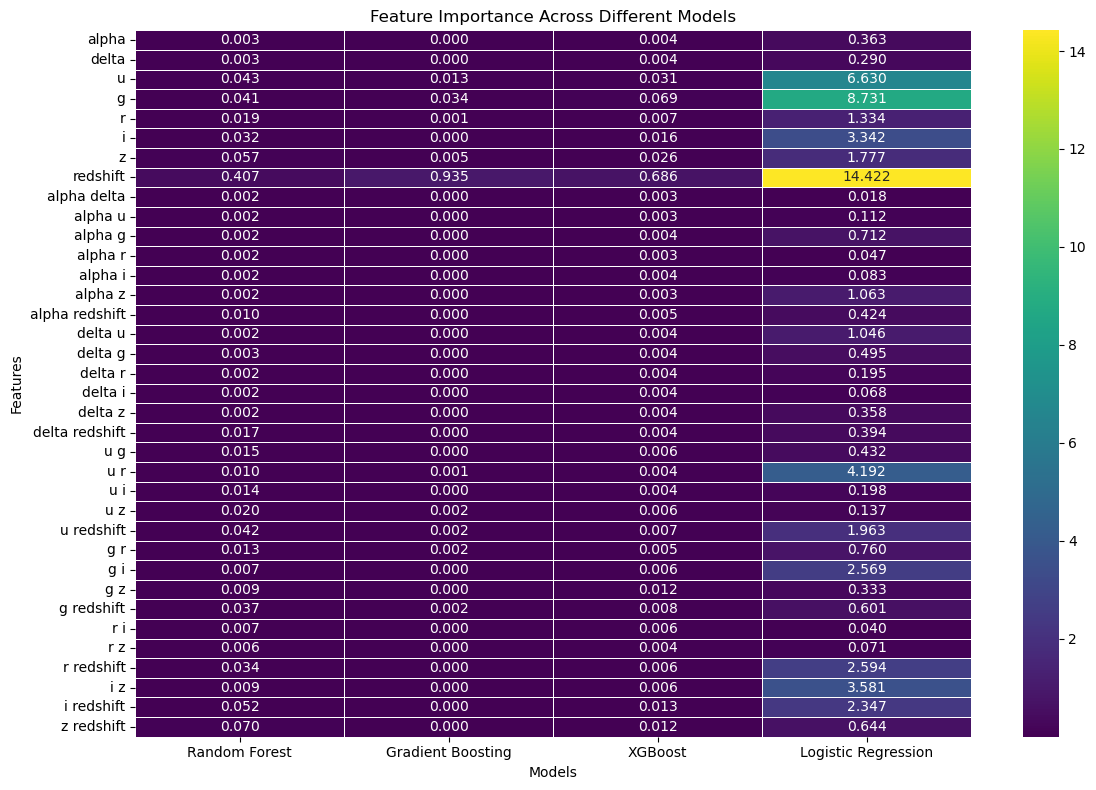

In [91]:
#compare feature importances Across Models

model_feature_importance = {}
models = [rf_classifier, gb_classifier, xgboost_classifier, logreg_classifier]
model_names = ["Random Forest", "Gradient Boosting", "XGBoost", "Logistic Regression"]

for model, name in zip(models, model_names):
    if hasattr(model, 'feature_importances_'):
        model_feature_importance[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        model_feature_importance[name] = np.abs(model.coef_[0])

importance_df = pd.DataFrame(model_feature_importance, index=poly_feature_names)

#heatmap showing feature
plt.figure(figsize=(12, 8))
sns.heatmap(importance_df, annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
plt.title('Feature Importance Across Different Models')
plt.xlabel('Models')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

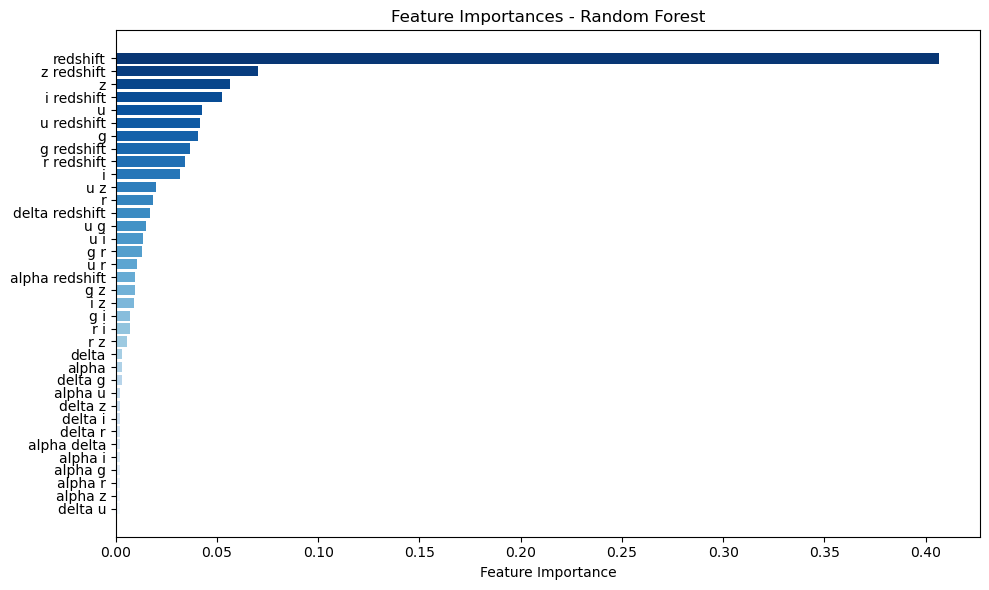

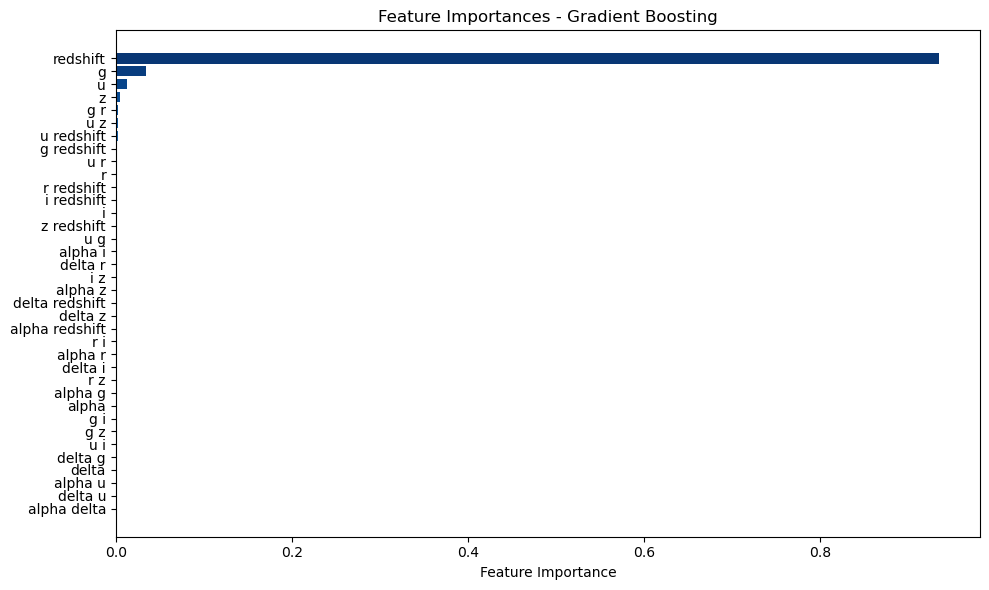

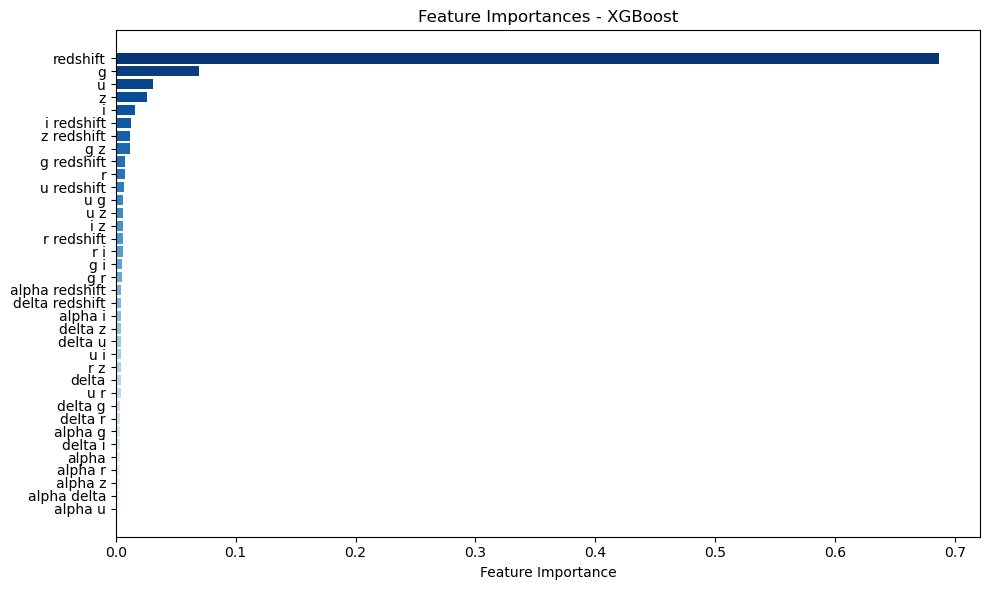

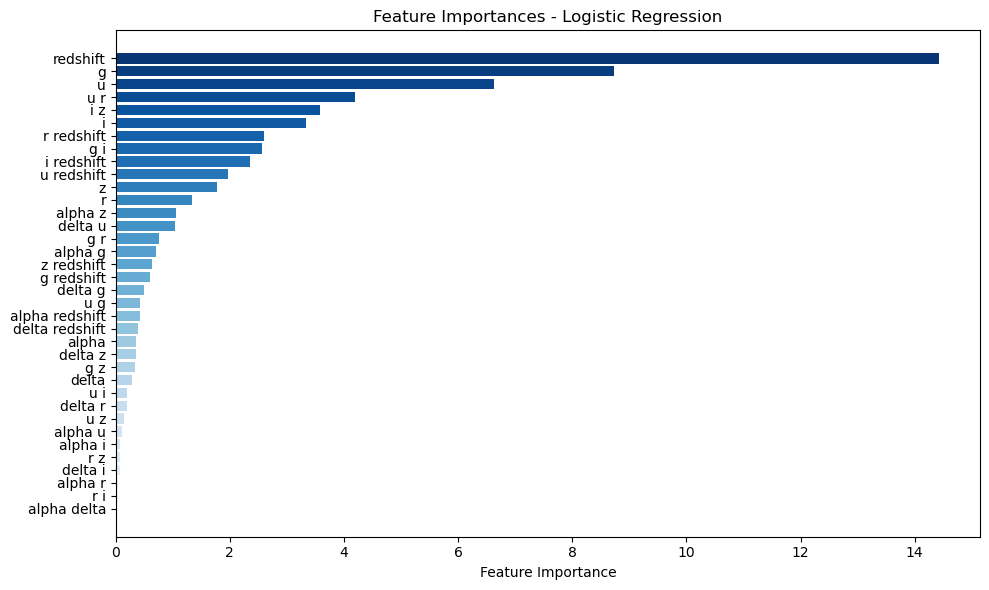

In [92]:
#plot feature importance for Each Model

#plot feature importance for random forest, gradient boosting, XGBoost, and logistic regression
plot_feature_importances(rf_classifier, "Random Forest", poly_feature_names)
plot_feature_importances(gb_classifier, "Gradient Boosting", poly_feature_names) 
plot_feature_importances(xgboost_classifier, "XGBoost", poly_feature_names)
plot_feature_importances(logreg_classifier, "Logistic Regression", poly_feature_names)

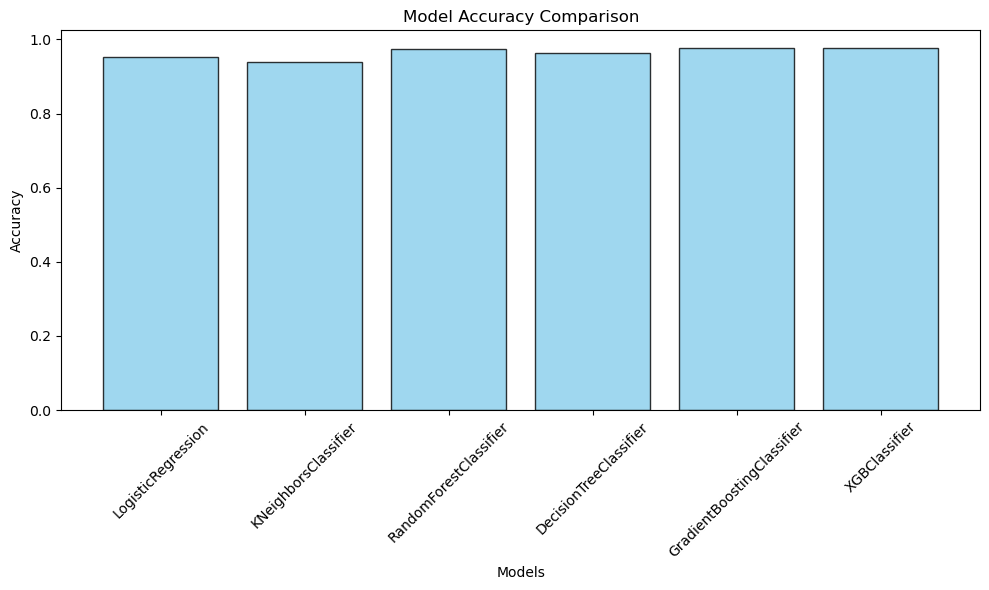

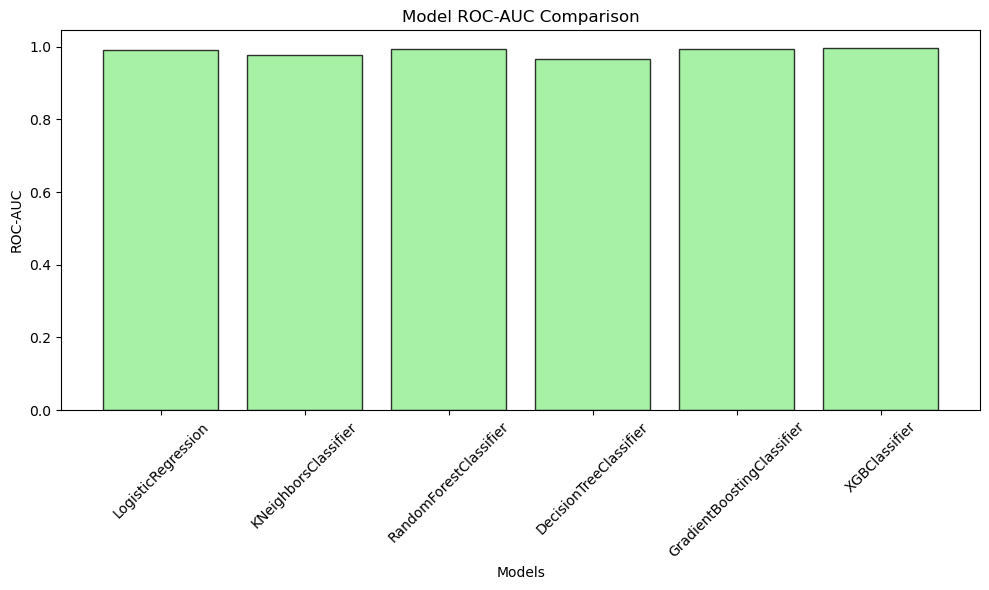

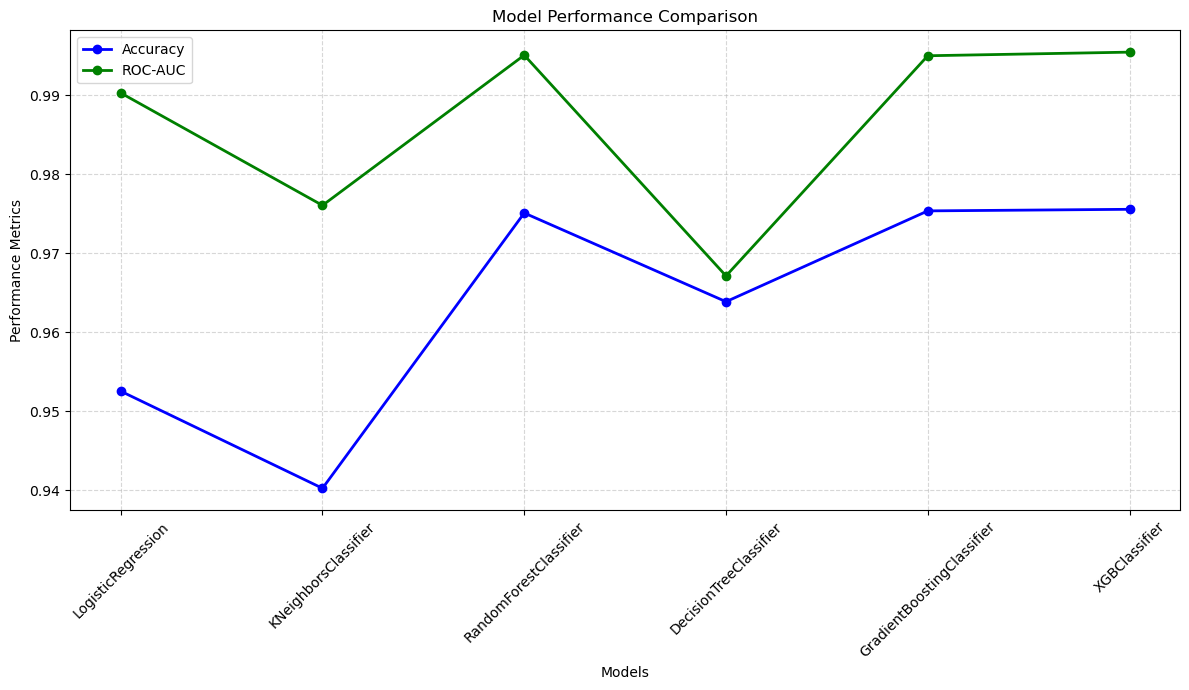

In [93]:
#Visualize Performance and Accuracy Differences

import matplotlib.pyplot as plt
import numpy as np


model_names = [result[0] for result in model_results] 
accuracies = [result[1] for result in model_results]
roc_aucs = [result[2] if result[2] != "N/A" else 0 for result in model_results]

#accuracy comparison: bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue', alpha=0.8, edgecolor='black')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#ROC-AUC comparison
plt.figure(figsize=(10, 6))
plt.bar(model_names, roc_aucs, color='lightgreen', alpha=0.8, edgecolor='black')
plt.title('Model ROC-AUC Comparison')
plt.xlabel('Models')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#combined performance comparison
plt.figure(figsize=(12, 7))
plt.plot(model_names, accuracies, marker='o', label='Accuracy', color='blue', linewidth=2)
plt.plot(model_names, roc_aucs, marker='o', label='ROC-AUC', color='green', linewidth=2)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Performance Metrics')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [94]:
#Overall summary output

models = [rf_classifier, gb_classifier, xgboost_classifier, logreg_classifier, knn_classifier, dt_classifier]

def print_summary():
    print("\n--- Overall Summary ---\n")
    
    # Best model based on accuracy
    best_model = sorted_models[0]
    print(f"Best Model: {best_model[0]}")
    print(f"Accuracy: {best_model[1]:.4f}")
    print(f"ROC-AUC: {best_model[2] if best_model[2] != 'N/A' else 'Not Available'}\n")
    
    print("Model Performance Summary:")
    print("{:<25} {:<10} {:<10}".format("Model", "Accuracy", "ROC-AUC"))
    print("-" * 50)
    for result in sorted_models:
        print("{:<25} {:<10.4f} {:<10}".format(result[0], result[1], result[2] if result[2] != "N/A" else "N/A"))
    
    best_model_instance = models[model_names.index(best_model[0])]
    if hasattr(best_model_instance, 'feature_importances_'):
        importance = best_model_instance.feature_importances_
        top_features = np.argsort(importance)[::-1][:5] 
        print("\nTop 5 Features of the Best Model:")
        for i in top_features:
            print(f"- {poly_feature_names[i]}: {importance[i]:.4f}")
    elif hasattr(best_model_instance, 'coef_'):
        importance = np.abs(best_model_instance.coef_[0])
        top_features = np.argsort(importance)[::-1][:5]  
        print("\nTop 5 Features of the Best Model:")
        for i in top_features:
            print(f"- {poly_feature_names[i]}: {importance[i]:.4f}")
    else:
        print("\nThe best model does not support feature importance.")

print_summary()



--- Overall Summary ---

Best Model: XGBClassifier
Accuracy: 0.9756
ROC-AUC: 0.9954715799175317

Model Performance Summary:
Model                     Accuracy   ROC-AUC   
--------------------------------------------------
XGBClassifier             0.9756     0.9954715799175317
GradientBoostingClassifier 0.9754     0.9950147551456568
RandomForestClassifier    0.9751     0.9950891140763746
DecisionTreeClassifier    0.9639     0.9671320600769837
LogisticRegression        0.9525     0.9903042177566114
KNeighborsClassifier      0.9402     0.9760638749540976

Top 5 Features of the Best Model:
- redshift: 0.8612
- g: 0.0322
- z: 0.0222
- u: 0.0150
- g z: 0.0100
